
### Objectiu del departament d'Anàlisi de Perfil Client:

> Quines combinacions de característiques demogràfiques (com edat, nivell educatiu i ocupació) són més comunes entre els clients que utilitzen múltiples productes financers del banc: loan, hipoteca, dipòsit?

### Llibreries i càrrega de dades

In [29]:
"""Libreries que poden ser necessàries"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"
from plottable import Table         # Visualización de tablas
import matplotlib.colors as mcolors # Colores y mapas de colores

# Clustering y agrupamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


ModuleNotFoundError: No module named 'kmodes'

In [ ]:
# %pip install plottable
# %pip install kmodes


Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_csv("../Data/df_250519.csv")

Paleta de colors

In [5]:
custom_palette = ["#AABBC8", "#2CCED1", "#5F6F81", "#DCE3EA", "#2E2F36"]  
sns.set_palette(sns.color_palette(custom_palette))

### Extracte KPIs

In [6]:

# Variables 
contactados   = df.nunique().id                                     # Número total de clientes contactados
suscribieron  = df[df['deposit'] == True].nunique().id             # Número de clientes que suscribieron 
duracion_llam = df[df['deposit'] == True].duration.sum()           # Duración de llamadas a suscriptores
llam_telf = df[df['contact'] == 'telephone']['campaign'].sum()      # Número de llamadas realizadas por teléfono
llam_cell = df[df['contact'] == 'cellular']['campaign'].sum()       # Número de llamadas realizadas por movil
llam = df['campaign'].sum()                                         # Número total de llamadas
contatos_previos_sus = df[df['deposit'] == True]['previous'].sum() # Número de contactos previos a suscriptores
suscribieron_por_mes = df[df['deposit'] == True].groupby('month').count()['deposit']  # Suscriptores en el mes
contactos_por_mes = df.groupby('month').count()['deposit']          # clientes contactados en el mes      
conversion_por_mes = suscribieron_por_mes / contactos_por_mes       # conversión por mes


# Prints
print("El número total de clientes contactados es:",contactados)
print("El número de suscriptores es:",suscribieron)
print("La duración total de las llamadas a suscriptores es:",duracion_llam)
print("El número de llamadas realizadas a teléfono fijo es: ", llam_telf)
print("El número de llamadas realizadas a móvil es: ", llam_cell)
print("El número total de llamadas realizadas es: ", llam)
print("El número total de contactos previos de los suscriptores es:", contatos_previos_sus)
print("La conversión por mes es: ", conversion_por_mes)

El número total de clientes contactados es: 16163
El número de suscriptores es: 7712
La duración total de las llamadas a suscriptores es: 4161406
El número de llamadas realizadas a teléfono fijo es:  3274
El número de llamadas realizadas a móvil es:  28002
El número total de llamadas realizadas es:  40513
El número total de contactos previos de los suscriptores es: 9149
La conversión por mes es:  month
Apr    0.632210
Aug    0.456830
Dec    0.910256
Feb    0.579892
Jan    0.408537
Jul    0.413684
Jun    0.447770
Mar    0.903704
May    0.334953
Nov    0.420236
Oct    0.837500
Sep    0.842333
Name: deposit, dtype: float64


In [7]:
#KPIs
kpi1 = suscribieron/contactados          # porcentaje de conversión a depósito
kpi2 = duracion_llam/suscribieron        # promedio de duración de llamadas a suscriptores
kpi3_tel = llam_telf/llam                # porcentaje de llamadas a teléfono
kpi3_cell = llam_cell/llam               # porcentaje de llamadas a móvil
kpi3 = (llam_telf+llam_cell)/llam        # porcentaje de llamadas a teléfono o móvil
kpi4 = contatos_previos_sus/suscribieron # promedio de contactos previos a suscriptores
kpi5 = conversion_por_mes.idxmax()       # mes con mayor tasa de conversión
kpi5_tasa = conversion_por_mes.max()     # tasa de conversión del mes con mayor tasa de conversión




# Prints
print("KPI 1: El porcentaje de conversión a depósito es ",kpi1*100,"%")
print("KPI 2: La duración media de las llamadas a suscriptoreses",kpi2)
# print("KPI 3: El porcentaje de llamadas realizadas por teléfono o móvil es ",kpi3*100,"%")
print("KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es ",kpi3_tel*100,"%")
print("KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es ",kpi3_cell*100,"%")
print("KPI 4: El porcentaje de contactos previos a suscriptores es ",kpi4)
print("KPI 5: El mes amb millor conversió ha sigut", kpi5, "amb una taxa de conversió de", kpi5_tasa)

KPI 1: El porcentaje de conversión a depósito es  47.713914496071276 %
KPI 2: La duración media de las llamadas a suscriptoreses 539.6014004149378
KPI 3.1: El porcentaje de llamadas realizadas por teléfono fijo es  8.081356601584677 %
KPI 3.2: El porcentaje de llamadas realizadas por teléfono móvil es  69.11855453804951 %
KPI 4: El porcentaje de contactos previos a suscriptores es  1.1863329875518671
KPI 5: El mes amb millor conversió ha sigut Dec amb una taxa de conversió de 0.9102564102564102


# Anàlisi 

Volem saber, 
de la gent que contracta els tres productes financers del banc:  prèstec (loan), hipoteca (housing), compte d'estalvi (deposit)

Quins són els perfils més comuns (3 variables)?


Comencem filtrant el df per els perfils que contracten aquest tres productes

In [17]:
# loan is yes, housing is yes, deposit is yes
# Número de clientes que suscribieron, tienen préstamo y una hipoteca
df_3contractats = df[(df['deposit'] == True) & (df['loan'] == True) & (df['housing'] == True)] # Df de clientes que suscribieron, tienen préstamo y una hipoteca

df_3contractats_numero = df_3contractats.nunique().id  # Número de clientes que cumplen las condiciones
print("El número de clientes que suscribieron, tienen préstamo y una hipoteca es:", df_3contractats_numero)



El número de clientes que suscribieron, tienen préstamo y una hipoteca es: 384


/var/folders/tj/x1zxmcgd19nbm3pz04lp5pv40000gn/T/ipykernel_8443/2855436753.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/tj/x1zxmcgd19nbm3pz04lp5pv40000gn/T/ipykernel_8443/2855436753.py:3: UserWarning:


The palette list has fewer values (5) than needed (12) and will cycle, which may produce an uninterpretable plot.



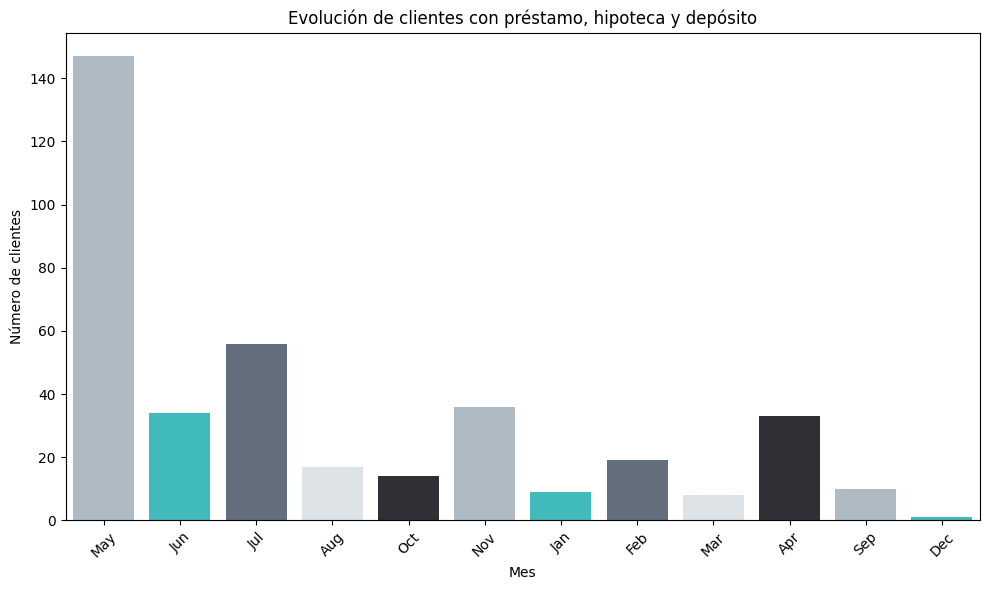

In [18]:
# Visualización de la evolución de los clientes que cumplen las condiciones
plt.figure(figsize=(10, 6))
sns.countplot(data=df_3contractats, x='month', palette=custom_palette)
plt.title('Evolución de clientes con préstamo, hipoteca y depósito')
plt.xlabel('Mes')
plt.ylabel('Número de clientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Agrupem el dataframe per la combinació de les característiques demogràfiques 
df_3contractats = df.groupby(['job', 'marital', 'education'])


# Creem una taula per al càlcul de conversions
taula_pefils = []

# Recorrem la taula calculant la conversió de cada grup
for (feina, estat_civil, educacio), grup in df_3contractats:
    contactats = grup.nunique().id

    # Afegim cada resultat a la taula
    taula_pefils.append({
        'feina': feina,
        'estat_civil': estat_civil,
        'educació': educacio,
        'contactats': contactats,
    })

# Convertim la taula de conversió en un dataframe 
taula_pefils = pd.DataFrame(taula_pefils)

taula_pefils = taula_pefils.set_index(['feina', 'estat_civil', 'educació'])  # Establim l'índex de la taula

# order by contactats
taula_pefils = taula_pefils.sort_values(by='contactats', ascending=False)  # Ordenem la taula per contactats

taula_pefils 

contactats
feina        estat_civil educació             
management   married     tertiary         1651
             single      tertiary         1137
blue-collar  married     secondary        1078
technician   married     secondary         935
admin.       married     secondary         796
...                                        ...
student      divorced    tertiary            2
management   single      primary             2
entrepreneur divorced    unknown             2
                         primary             2
unemployed   divorced    unknown             1

[132 rows x 1 columns]